<a href="https://colab.research.google.com/github/gaxler/dl-arpeggio/blob/master/demos/sorter_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/gaxler/dl-arpeggio.git
!pip install -U -r dl-arpeggio/requirements.txt
!mv dl-arpeggio/base.toml .
!cd dl-arpeggio; git pull;

Cloning into 'dl-arpeggio'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 89 (delta 39), reused 79 (delta 30), pack-reused 0
Unpacking objects: 100% (89/89), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 185 kB/s 
     |████████████████████████████████| 68 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 59.3 MB/s 
     |████████████████████████████████| 145 kB 57.8 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
  Created wheel for jax: filename=jax-0.3.24-py3-none-any.whl size=1297425 sha256=e95b7070f6986e95b8d853e029dd13693fc739fa18e8bd44124790739c7e1b36
  Stored in directory: /root/.cache/pip/wheels/4c/51/9d/cc990e5e0d5e96026639b08f02e8bb5e93ab1574ed2105178f
Successfully built jax
  Attempting uninstall: typing-extensions
    Found existing installatio

In [2]:
import sys
sys.path.insert(0, "/content/dl-arpeggio/arpeggio/")

In [3]:
import math
from einops import rearrange
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np

from transformers.model import GPT, CausalAttention, TransformerBlock, TransformerMLP

import matplotlib.pyplot as plt
import seaborn as sns

from gpt_sorter import TrainerConf, train, GPTTrainer


In [4]:
SEED = 1337
base_key = jrandom.PRNGKey(SEED)

trainer_conf = TrainerConf.from_toml("base.toml")
base_key, gpt_init_key = jrandom.split(base_key, 2)
gpt = train(trainer_conf, gpt_init_key)

[00003] Loss: 3.2984
Epoch: 1:
Rows:
	Out of dist Seq | GT Training Seq | Predicted Training Seq 
	37 31 -> <EOS> <EOS> <EOS>
	3 7 5 -> <EOS> <EOS> <EOS> <EOS>
	11 5 17 7 -> <EOS> <EOS> <EOS> <EOS> <EOS>
	37 31 29 23 19 -> 5 14 21 29 29 <EOS>
	5 17 7 13 19 -> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

	32 0 28 0 9 -> 0 0 9 28 32 <EOS>
	32 0 28 0 9 -> 5 6 <EOS> <EOS> <EOS> <EOS>
[00006] Loss: 2.8975
[00009] Loss: 2.7059
[00012] Loss: 2.6490
[00015] Loss: 2.6063
[00018] Loss: 2.4997
[00021] Loss: 2.5299
[00024] Loss: 2.4623
[00027] Loss: 2.4680
[00030] Loss: 2.3480
[00033] Loss: 2.2595
[00036] Loss: 2.2419
[00039] Loss: 2.1885
[00042] Loss: 2.0561
[00045] Loss: 2.0168
[00048] Loss: 1.9410
[00051] Loss: 1.8465
[00054] Loss: 1.7952
[00057] Loss: 1.7233
[00060] Loss: 1.6688
[00063] Loss: 1.5022
[00066] Loss: 1.5051
[00069] Loss: 1.3879
[00072] Loss: 1.3458
[00075] Loss: 1.3048
[00078] Loss: 1.2548
[00081] Loss: 1.2054
[00084] Loss: 1.1967
[00087] Loss: 1.1048
[00090] Loss: 1.0679
[00093] Lo

Forward pass of the GPT with exposed internal to allow visualizations of the internals

In [5]:
def embed(model: GPT, idxs):
  inp_seq_len = idxs.shape[0]
  pos_idxs = jnp.arange(0, inp_seq_len)
  
  tok_emb = model.token_emb[idxs]
  pos_emb = model.pos_emb[pos_idxs]
  return tok_emb, pos_emb

def apply_attn(attn: CausalAttention, x):
  kqv_mat = jax.vmap(attn.kqv_enc)(x)
  k, q, v = jnp.split(kqv_mat, 3, axis=-1)

  split_to_heads = lambda mat: rearrange(mat, "t (d h) -> h t d", h=attn.n_heads)
  k, q, v = split_to_heads(k), split_to_heads(q), split_to_heads(v)
  mask = jnp.tril(jnp.ones((1, q.shape[1], k.shape[1])))

  qk_inner_prod = jnp.einsum("hqd,hkd->hqk", q, k)
  logits = qk_inner_prod / math.sqrt(1 / k.shape[-1])
  logits = jnp.where(mask, logits, -jnp.inf)
  attn_w = jax.nn.softmax(logits, axis=-1)

  headed_vals = jnp.einsum("hqK,hKd->hqd", attn_w, v)

  headed_vals = rearrange(headed_vals, "h q d -> q (h d)")

  # project head values over temporal dim
  values = jax.vmap(attn.head_proj)(headed_vals)

  return values, (k, q, v, logits, attn_w)

def apply_mlp(mlp: TransformerMLP, x):
  """ Don't have a good reason to open-up the MLP  """
  return jax.vmap(mlp)(x)

def apply_block(block: TransformerBlock, x):
  _x = block.ln_attn(x)

  dx_attn, attn_internals = apply_attn(block.attn, _x)
  x = x + dx_attn

  _x = block.ln_mlp(x)
  dx_mlp = apply_mlp(block.mlp, _x)
  x = x + dx_mlp
  return x, (dx_attn, dx_mlp), attn_internals


def _unzip(lst_of_tups):
    lst_of_lst = [[] for _ in lst_of_tups[0]]
    for tup in lst_of_tups:
        for idx, v in enumerate(tup):
            lst_of_lst[idx].append(v)
    return lst_of_lst


def gpt_step(model: GPT, x):
    tok_emb, pos_emb = embed(model, x)
    x_0 = tok_emb + pos_emb

    x = x_0
    dxs = []
    attn_internals = []  # (k,q,v, logits, attn_w)

    for block in model.blocks:
        x, dx_attn_mlp, _attn_intr = apply_block(block, x)
        dxs.append(dx_attn_mlp)
        attn_internals.append(_attn_intr)

    x = model.final_ln(x)
    logits = jax.vmap(model.classifier)(x)

    return logits, (x_0, _unzip(dxs), _unzip(attn_internals)), (tok_emb, pos_emb)


Run a forward pass and get the $X_0$ that gets updated as the attention moves along

In [6]:
sorting_task = trainer_conf.task
dataloader = sorting_task.get_dataloader(batch_size=2)

batch = next(dataloader)
logits, (x_0, (dx_attn, dx_mlp), (k,q,v, attn_logits, attn_w)), (emb_tok, emb_pos) = gpt_step(gpt, batch.tokens[0])

## Plotting Attention Maps
Looking at actual attention weights and attention of raw token and positional embeddings

In [7]:
def plot_attn_heads(vals, ncols=2, nrows=2, figsize=(10, 7), title=None):
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
  for ridx, rax in enumerate(axs):
    for cidx, ax in enumerate(rax):
      idx = nrows*ridx + cidx
      sns.heatmap(vals[idx], ax=ax);
  if title is not None:
    fig.suptitle(title, fontsize=12)

to_h = lambda mat: rearrange(mat, "t (d h) -> h t d", h=trainer_conf.gpt.attention.num_heads)

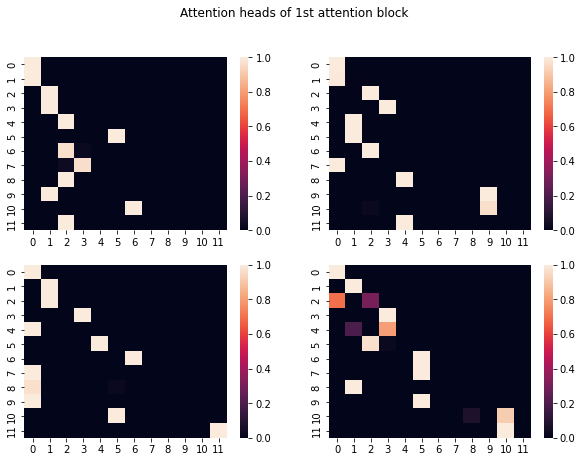

In [8]:
plot_attn_heads(attn_w[0], title="Attention heads of 1st attention block")

### Position-Embeddings attention

Cross attention between positional embeddings (as keys) and token embeddings (as queries)



In [9]:
BLOCK = 0
KQV_pos = jax.vmap(gpt.blocks[BLOCK].attn.kqv_enc)(gpt.pos_emb)
KQV_tok = jax.vmap(gpt.blocks[BLOCK].attn.kqv_enc)(gpt.token_emb)
K_pos, Q_pos, V = KQV_pos.split(3,axis=-1)
K_tok, Q_tok, V = KQV_tok.split(3,axis=-1)

def get_inner_p_map(keys, queries, num_heads = 4):
  inner_p = jnp.einsum("hqd,hkd->hqk", to_h(queries), to_h(keys)) * (1 / math.sqrt(keys.shape[-1] / num_heads))
  inner_p = jax.nn.softmax(inner_p, axis=-1)
  return inner_p

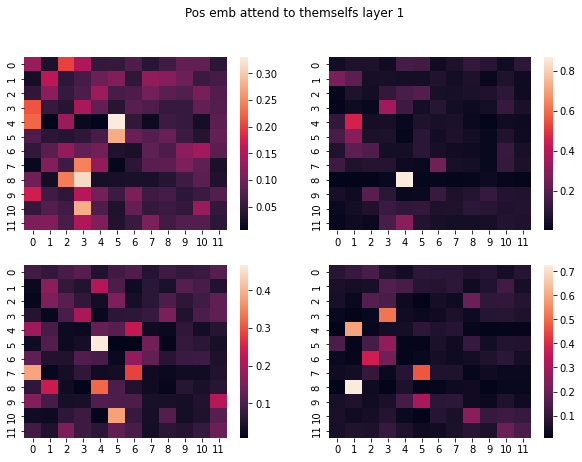

In [10]:
pos_attn = get_inner_p_map(K_pos, Q_pos)
plot_attn_heads(pos_attn, title=f"Pos emb attend to themselfs layer {BLOCK+1}")

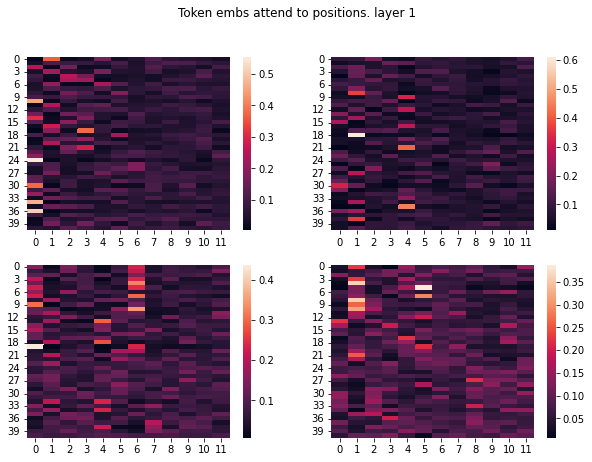

In [11]:
cross_attn = get_inner_p_map(K_pos, Q_tok)
plot_attn_heads(cross_attn, title=f"Token embs attend to positions. layer {BLOCK+1}")